# Principal Component Analysis

An important decision to make when training machine learning models is the the features to use for the training dataset. Principal Component Analysis allows you to see which features account for most of the variance, simplifying the dataset to a smaller number of correlated variables. 

In [1]:
import numpy as np

%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scienceplots
from celluloid import Camera

from IPython.display import Image

np.random.seed(0)
plt.style.use(["science", "no-latex"])

## Target Dataset

Let's generate a noisy list of points by generating points between a start and end point and by adding random noise to each point

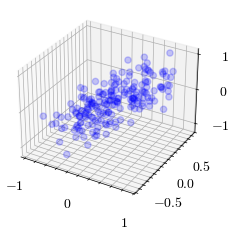

In [2]:
def generate_noisy_hyperplane(num_points, start_pt, end_pt, noise=0.25):
    # create a plane from the start to the end point
    t = np.linspace(0.0 + noise, 1.0 - noise, num_points).reshape(-1, 1)
    points = start_pt + t * (end_pt - start_pt)

    # add noise to plane
    noise = np.random.normal(0, noise, size=(num_points, 3))
    points = points + noise

    return points


start_pt = np.array([-1, -1, -1])
end_pt = np.array([1, 1, 1])
X = generate_noisy_hyperplane(200, start_pt, end_pt)

# plot the points
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.2, color="blue", label="Original Data")
plt.show()

## Eigenvectors and Eigenvalues

When you multiply a matrix with its eigenvector, you get a multiple of the eigenvector. The scalar multiple is the eigenvector's eigenvalue. The process of finding the eigenvectors and eigenvalues of a matrix is called Eigendecomposition.

$$A \vec{v} = \lambda \vec{v}$$

The scalar $\lambda$ is the eigenvalue and the vector $\vec{v}$ is the corresponding eigenvector. The eigendecomposition typically involves solving the determinant $det(A - \lambda I) = 0$, where $I$ is the identity matrix.

Use numpy to quickly get the eigenvalues and eigenvectors of a matrix

```py
import numpy as np
mat = np.array([[4, -2],
                [1,  1]])
eig_vals, eig_vecs = np.linalg.eig(mat)
```

## Lagrange Multipliers (Optimization with constraints)

Recall from Multivariable Calculus that Lagrange Multipliers allow you to find the extrema of a function $f(x, y, z, ...)$ that is subject to a constraint function $g(x, y, z, ...)=0$. 

The Lagrange Multipliers technique states that the solution of this constrainted optimization problem is the solution to the following  system of equations:

$$\nabla L = 0$$

where

$$L(x, y, z, ... \lambda) = f(x, y, z, ... \lambda) - \lambda g(x, y, z, ... \lambda)$$

## PCA Derivation (Eigendecomposition of Covariance Matrix)

Recall that our goal is to find the vectors $v$ that account for most of the variance. 

Given input vector $x_i$ and vector $v$, we want to project every input point to $v$ in each dimension.

$$z_i = x_i^Tv$$

The variance is 

$$(x_i^Tv)^2 = z_i^2$$

To find the maximum variance across all of the projections for the $n$ dimensions.

$
\begin{align*}
\max \sum_{i=1}^{n} (x_i^Tv)^2 &= \max \sum_{i=1}^{n} z_i^2 \\ 
&= \max z^Tz \\ 
&= \arg\max (xv)^Txv \\ 
\end{align*}
$

Since the ratios of the Principal Components is all that matters, let's introduce the constaint that
$$v^Tv = 1$$

Solving the constrainted optimization with Lagrange Multipliers, we define the Lagrangian function: 

$$ L = \arg\max v^Tx^Txv - \lambda (v^Tv - 1)$$

Let's solve the Lagrangian function by solving $\nabla L = 0$

$
\begin{align*}
0 &= \frac{\partial L}{\partial v} \\ 
&= \frac{\partial}{\partial v}[v^Tx^Txv - \lambda (v^Tv - 1)]  \\ 
&= 2x^Txv - 2\lambda v  \\
&= x^Txv - \lambda v  \\
&= (x^Tx)v - \lambda v  \\
(x^Tx)v &= \lambda v  \\
\end{align*}
$

Given that $x^Tx$ is the covariance of a matrix, we see that the solution to PCA is simply the eigendecomposition of the covariance matrix.

## PCA Implementation

To recap the two sections above, PCA consists of the following parts:
1. Standard the input data by dividing the difference of the data and the mean by the standard deviation.
2. Compute the covariance matrix of the standardized input
3. Compute eigenvalues and eigenvectors of the covariance matrix
4. To get the projected data, matrix multiply the standardized input and the eigenvectors.

In [3]:
def pca(X, dims):
    # subtract the mean to center the data and divide by standard deviation
    X_centered = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    # compute covariance matrix
    cov = np.cov(X_centered.T)

    # eigendecomposition of the covariance matrix
    # the eigenvectors are the principal components
    # the principal components are the columns of the eig_vecs matrix
    eig_vals, eig_vecs = np.linalg.eig(cov)

    # sort the eigenvalues and eigenvectors
    sorted_idx = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[sorted_idx]
    eig_vecs = eig_vecs[:, sorted_idx]

    # perform dimensionality reduction using the computed principal components
    # if you want to reduce to K dimensions, simplify take the first K columns
    projected = X_centered @ eig_vecs

    # compute the variance of each dimension (column)
    pc_variances = [np.var(projected[:, i]) for i in range(dims)]

    return eig_vals, eig_vecs, projected, pc_variances

## Graphing Functions

Utility functions to create the visualizations

In [4]:
def create_plots():
    fig = plt.figure(figsize=(16 / 9.0 * 4, 4 * 1))
    fig.suptitle("Principal Component Analysis")

    ax0 = fig.add_subplot(121, projection="3d")
    ax0.set_xlabel("X")
    ax0.set_ylabel("Y")
    ax0.set_zlabel("Z")
    ax0.set_title("PC Hyperplanes")
    ax0.view_init(17, -125, 2)
    ax0.set_xlim(-1, 1)
    ax0.set_ylim(-1, 1)
    ax0.set_zlim(-1, 1)
    ax0.tick_params(axis="both", which="both", length=0)

    ax1 = fig.add_subplot(122, projection="3d")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    ax1.set_title("Projected Data")
    ax1.view_init(17, -125, 2)
    # ax1.set_xlim(-1, 1)
    # ax1.set_ylim(-1, 1)
    # ax1.set_zlim(-1, 1)
    ax1.tick_params(axis="both", which="both", length=0)
    # plt.axis('equal')

    camera = Camera(fig)
    return ax0, ax1, camera


def plot_hyperplane(ax, pc_vector, color="red", scaling=10, alpha=0.3):
    # Create a grid of points
    points = np.linspace(-1, 1, scaling)
    xx, yy = np.meshgrid(points, points)

    # the z value is the defined by the hyperplane from the principal component vector
    pc_vector /= np.linalg.norm(pc_vector)
    z = (-pc_vector[0] * xx - pc_vector[1] * yy) / pc_vector[2]

    ax.plot_surface(xx, yy, z, color=color, alpha=alpha)

## Visualize PCA

Given the derivation of PCA, let's visualize the projected data with different values for the target dimension. 

In [5]:
def visualize_pca(X, dims, output_filename):
    ax0, ax1, camera = create_plots()
    colors = ["red", "green", "blue"]

    for dim in range(0, dims + 1):
        eig_vals, eig_vecs, projected, pc_variances = pca(X, dims)

        # plot the original data
        ax0.scatter(X[:, 0], X[:, 1], X[:, 2], color="blue", label="Original Data")

        # plot the pca hyperplanes
        for i in range(dim):
            plot_hyperplane(ax0, eig_vecs[:, i], color=colors[i])

        # plot the projected data from the principal components
        curr_projected = projected
        for i in range(dim, dims):
            if i < dims:
                curr_projected[:, i] = 0
        if dim != 0:
            ax1.scatter(
                curr_projected[:, 0],
                curr_projected[:, 1],
                curr_projected[:, 2],
                color="blue",
                label="Projected Data",
            )

        camera.snap()

    animation = camera.animate(interval=2000)
    animation.save(output_filename, writer="pillow")
    plt.show()

    eig_vals, eig_vecs, projected, pc_variances = pca(X, dims)

    print("variance percentage per principal component")
    variance_percentage = eig_vals / np.sum(eig_vals)
    for i, percentage in enumerate(variance_percentage):
        print(f"{i+1}th PC: {round(percentage*100, 2)}%")

    print("variance per principal component")
    for i, variance in enumerate(pc_variances):
        print(f"{i+1}th PC: {round(variance, 2)}")

    print("\nhyperplanes")
    for i in range(dim):
        print(f"hyperplane {i}: {eig_vecs[:, i]}")

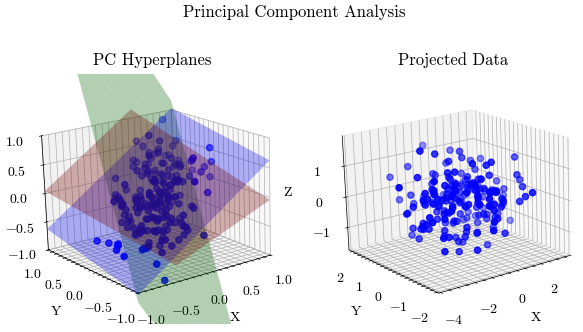

variance percentage per principal component
1th PC: 69.12%
2th PC: 17.52%
3th PC: 13.36%
variance per principal component
1th PC: 2.07
2th PC: 0.53
3th PC: 0.4

hyperplanes
hyperplane 0: [-0.58180084 -0.55533668 -0.59422972]
hyperplane 1: [ 0.51390531 -0.81729222  0.26064299]
hyperplane 2: [-0.63040394 -0.1537355   0.76089176]


In [6]:
dims = 3
output_filename = "pca.gif"

visualize_pca(X, dims, output_filename)

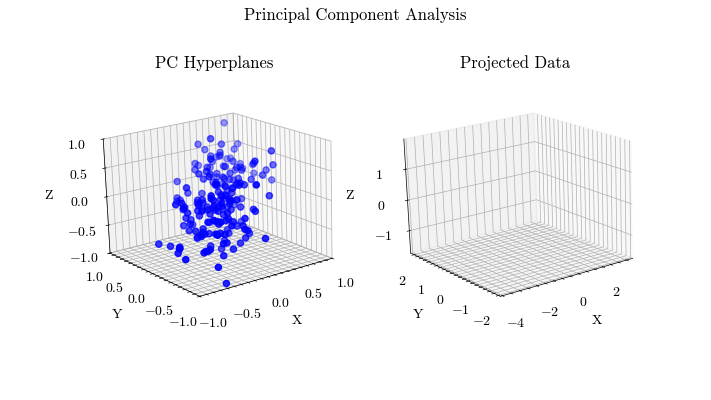

In [7]:
Image(filename=output_filename)

## Scikit-Learn Implementation

As a check for correctness, let's compare our results with the PCA module from scikit-learn.

Note: The sign of the values might not match exactly. They just need to have the same ratios, which they do. Our implementation matches the one from scikit-learn.

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_centered = scaler.fit_transform(X)

pca = PCA(n_components=dims)
projected = pca.fit_transform(X_centered)
eig_vecs = pca.components_

print("\nhyperplanes")
for i in range(dims):
    print(f"hyperplane {i}: {eig_vecs[i]}")


hyperplanes
hyperplane 0: [0.58180084 0.55533668 0.59422972]
hyperplane 1: [-0.51390531  0.81729222 -0.26064299]
hyperplane 2: [-0.63040394 -0.1537355   0.76089176]


Let's also plot scikit's learn projected data. Our implementation seems to match for the projected as well.

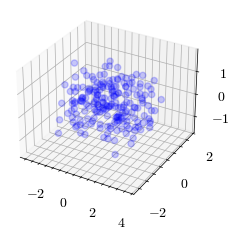

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(projected[:, 0], projected[:, 1], projected[:, 2], alpha=0.2, color="blue", label="Projected Data")
plt.show()